In [1]:
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,10)
plt.style.use("~/.dracula.mplstyle")
import seaborn as sns
import statsmodels.api as sm

In [2]:
class DataImport:
    
    def __init__(self, filename, add_ind=[]):
        self.xlsx = pd.ExcelFile("factor.xlsx")
        self.add_ind = add_ind # Additional indices to try to 
        
        print(f"Read in <{filename}>.")
        self.sheets = []
        print('-'*20, "Reading Sheets ", '-'*20)
        self.read_sheets()
        print('-'*20, "Setting Indices", '-'*20)
        self.set_indices()
        print('-'*20, "Checking Nulls ", '-'*20)
        self.check_nulls()
        print("\n\n")
    
    def read_sheets(self):
        for i, s in enumerate(self.xlsx.sheet_names):
            read_sheet = self.xlsx.parse(s)
            print(f"Sheet {i}: {s}; shape={read_sheet.shape}")
            self.sheets.append(read_sheet)
    
    def set_indices(self):
        for s in self.sheets:
            for d in ["date", "Date", "Unnamed: 0"]+self.add_ind:
                try:
                    s.set_index(d, inplace=True) # Date as index
                    break
                except KeyError:
                    continue
    
    def check_nulls(self):
        n = 0
        for i, s in enumerate(self.sheets[1:]):
            has_nulls = True
            while has_nulls:
                try:
                    assert sum(s.isna().sum())==0 # Check for nulls
                    has_nulls = False
                except AssertionError:
                    print(f"Null values found in <{i}>. Interpolating linearly.")
                    s = s.interpolate() # Linerly interpolate nulls
                    n += 1
        if n==0: print("No nulls found :)")

xl = DataImport("factor.xlsx")
xl.sheets[0]

Read in <factor.xlsx>.
-------------------- Reading Sheets  --------------------
Sheet 0: descriptions; shape=(7, 5)
Sheet 1: factors (excess returns); shape=(501, 7)
Sheet 2: portfolios (excess returns); shape=(501, 50)
Sheet 3: risk-free rate; shape=(501, 2)
-------------------- Setting Indices --------------------
-------------------- Checking Nulls  --------------------
No nulls found :)





,Name,Unit,Construction,Description
Unnamed: 0,,,,
MKT,Market,Excess Return,Market-cap-weighted,US Equities
SMB,Size,Excess Return,Small Minus Big,Long small stocks and short big stocks
HML,Value,Excess Return,High Minus Low,Long value (high book-to-market) stocks and sh...
RMW,Profitability,Excess Return,Robust Minus Weak,Long profitability (income statement) and shor...
CMA,Investment,Excess Return,Conservative Minus Agressive,Long stocks with low (conservative) investment...
UMD,Momentum,Excess Return,Up Minus Down,Long stocks that have high recent returns and ...
RF,Risk-free rate,Total Return,Tbills,NaN


In [3]:
fa = xl.sheets[1]
fa.head()

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
1980-01-31,0.0551,0.0182,0.0175,-0.0169,0.0171,0.0755
1980-02-29,-0.0122,-0.0158,0.0061,0.0007,0.0270,0.0788
1980-03-31,-0.1290,-0.0692,-0.0101,0.0145,-0.0116,-0.0955
1980-04-30,0.0397,0.0105,0.0108,-0.0206,0.0027,-0.0043
1980-05-31,0.0526,0.0210,0.0038,0.0032,-0.0032,-0.0112


# 2. The Factors

Use the data found in ‘factor pricing data.xlsx’.

• FACTORS: Monthly excess return data for the overall equity market, r ̃MKT. The sheet also
contains data on five additional factors. All factor data is already provided as excess returns.2

#### 1. Analyze the factors, similar to how you analyzed the three Fama-French factors in Homework 4.
You now have three additional factors, so let’s compare there univariate statistics. • mean

• volatility

• Sharpe

In [4]:
def pivot_summaries(data, year_mask=None, pi=0.05, nper=12):
    if not(year_mask):
        year_mask = [(str(min(data.index).year), str(max(data.index).year))]
    
    data_melt = pd.melt(data, ignore_index=False).sort_index()
    
    # Build Aggregation Functions here
    def me(x):
        return nper * np.mean(x)
    def sd(x): 
        return np.sqrt(nper) * np.std(x)
    def sr(x):
        return np.sqrt(nper) * np.mean(x) / np.std(x)
    def qt(x):
        return np.quantile(x, pi)
    
    af = [me, sd, sr, qt]
    af_names = ["Mean", "Vol", "Sharpe", f"VaR({pi})"]
    
    pivlist = []
    for start, end in year_mask:
        piv = pd.pivot_table(data_melt[start:end], index="variable", values="value",
                             aggfunc=af)
        piv.columns = pd.MultiIndex.from_arrays([[f"{start}-{end}"] * len(af), af_names],
                                                names=["year", "measure"])
        pivlist.append(piv)

    summ = pd.concat(pivlist, axis=1)
    return summ

summ = pivot_summaries(fa)
summ

year     1980-2021                        
measure       Mean    Vol Sharpe VaR(0.05)
variable                                  
CMA         0.0296 0.0685 0.4318   -0.0263
HML         0.0229 0.1060 0.2159   -0.0418
MKT         0.0873 0.1552 0.5624   -0.0721
RMW         0.0425 0.0826 0.5140   -0.0279
SMB         0.0135 0.1009 0.1334   -0.0423
UMD         0.0646 0.1555 0.4154   -0.0682

#### 2. Based on the factor statistics above, answer the following.

(a) Does each factor have a positive risk premium (positive expected excess return)?

Yes, all of the factors have a positive risk premium from 1980-2021.

(b) How have the factors performed since the time of the case, (2015-present)?

All factors trail behind the overall equity market in return, risk, and Sharpe Ratio. The market has a strongest expected excess return and Sharpe ratio at 0.0873 and 0.5624 respectively. All other factors trail substantially in mean, Sharpe Ratio, or both. The factor with the second highest expected return Up Minus Down has the fourth highest Sharpe Ratio. The factor with the second highest Sharpe Ratio Robust Minus Weak has the third highest expected return.

#### 3. Report the correlation matrix across the six factors.

(a) Does the construction method succeed in keeping correlations small?

In a sense it minimizes correlations, yet with so many factors, it may be difficult to mimize the strongest correlations. The overall market is not strongly correlated with the remaining factors, yet between the other factors, some large relationships exist. For example, Conservative Minus Aggerssive and High Minus Low are strongly positively correlated.

(b) Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case?

Because the Fama French 5 Factor model includes Conservative Minus Aggressive, High Minus Low is redundant. At a correlation of 0.66, it exhibits strong multicollinearity of used for decomposition.

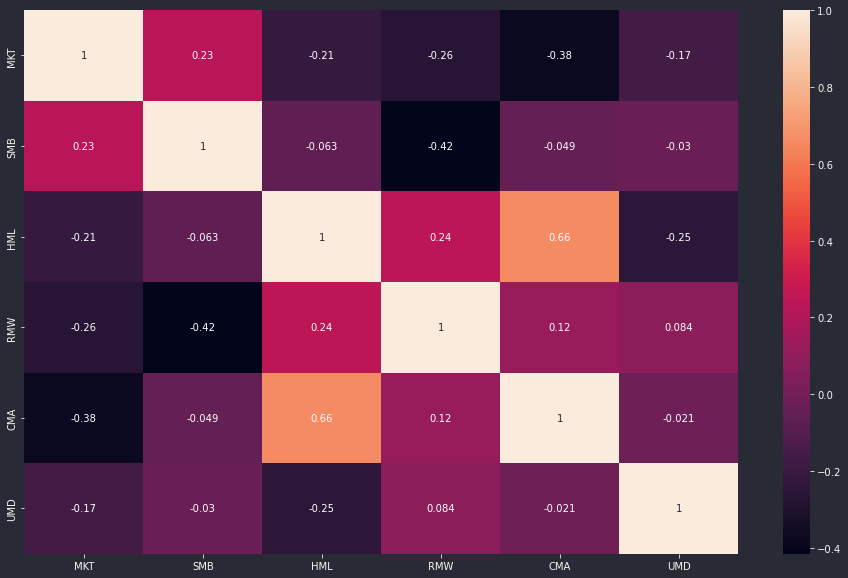

The pair with the HIGHEST correlation is ('CMA', 'HML') at 0.657629597012911
The pair with the LOWEST  correlation is ('RMW', 'SMB') at -0.4153220754696025


In [5]:
def disp_corr(df):
    c = df.corr()
    sns.heatmap(c, annot=True); plt.show()
    
    cu = c.unstack().sort_values(ascending=False)
    cu = cu[c.shape[0]:] # There are c.shape[0] 1's in the corr matrix. Skip them.

    print(f"The pair with the HIGHEST correlation is {cu.idxmax()} at {cu.max()}")
    print(f"The pair with the LOWEST  correlation is {cu.idxmin()} at {cu.min()}")

disp_corr(fa)

#### 4. Report the tangency weights for a portfolio of these 6 factors.

(a) Which factors seem most important? And Least?

CMA, RMW, and MKT have the highest weightings in order. HML, SMB, and UMD have the lowest weightings in order. The weightings can be interpreted as the importance rating of an MV portfolio.

(b) Are the factors with low mean returns still useful?

Yes, CMA has the third lowest mean return but the highest weighting. Likewise, RMW has the fourth lowest return and the second highest weighting. Therefore it is safe to conclude that mean return is but a small factor in allocation to the Mean Variance Tangency portfolio.

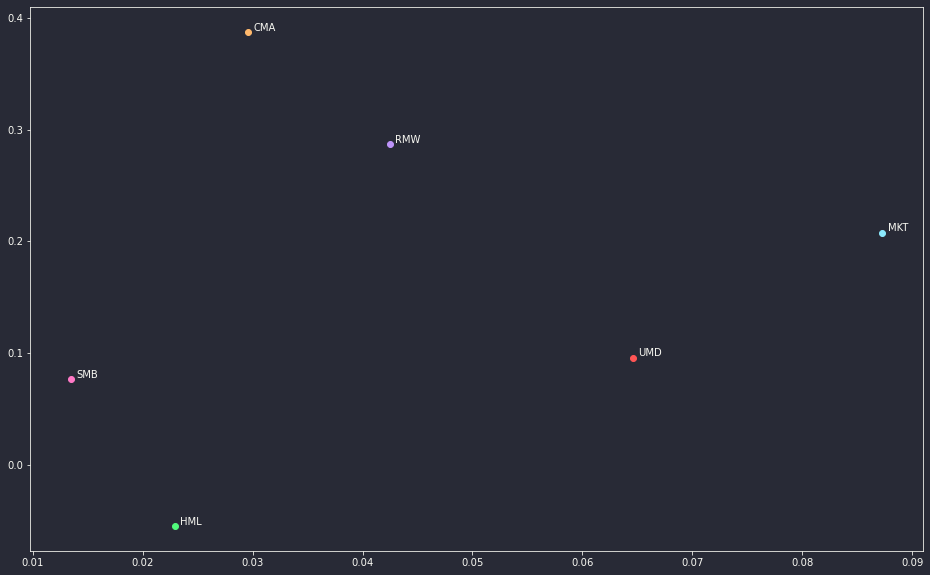

,wtan,mean
MKT,0.2078,0.0873
SMB,0.0766,0.0135
HML,-0.0549,0.0229
RMW,0.2870,0.0425
CMA,0.3875,0.0296
UMD,0.0960,0.0646


In [6]:
def mvtan(cov, mu):
    wt = np.linalg.inv(cov.values) @ mu
    return pd.Series(wt / sum(wt), index=cov.index)

def scatter_frame(df, x, y, xoff, yoff):
    for c, r in df.iterrows():
        plt.scatter(r[x], r[y], label=c)
        plt.annotate(c, (r[x]+xoff, r[y]+yoff))
    plt.show()

c, m = fa.cov(), fa.mean() * 12

all_mv = mvtan(c, m)
mvw = pd.DataFrame({"wtan":all_mv, "mean":m})

xoff, yoff = 0.0005, 0.001

scatter_frame(mvw, x="mean", y="wtan", xoff=xoff, yoff=yoff)
mvw

(c) Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. Which factors get high/low tangency weights now?

HML moved from the lowest weighted to the highest. However, SMB gets optimized to near zero weight.

What do you conclude about the importance or unimportance of these styles?

Each style mean variance optimization attempts to produce the highest sharpe ratio given selected factors. When certain factors are missing, the optimizer must balance the covariances between the remaining factors to achieve its goal, and therefore may produce significantly different weightings after the addition or subtraction of few factors.

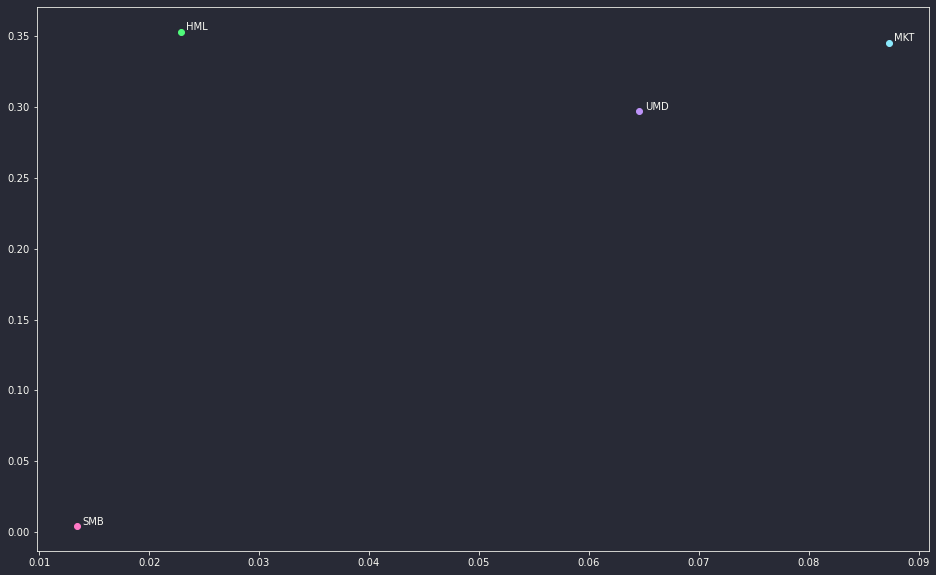

,wtan,mean
MKT,0.3455,0.0873
SMB,0.0041,0.0135
HML,0.3532,0.0229
UMD,0.2973,0.0646


In [7]:
sub_fa = fa[["MKT", "SMB", "HML", "UMD"]]

sub_c, sub_m = sub_fa.cov(), sub_fa.mean() * 12

sub_mv = mvtan(sub_c, sub_m)
sub_mvw = pd.DataFrame({"wtan":sub_mv, "mean":sub_m})

scatter_frame(sub_mvw, x="mean", y="wtan", xoff=xoff, yoff=yoff)
sub_mvw

In [8]:
v_mv = fa @ all_mv
v_sub = sub_fa @ sub_mv

s_mv = pivot_summaries(pd.DataFrame({"all_factors": v_mv, "subset_factors": v_sub}))
s_mv

year           1980-2021                        
measure             Mean    Vol Sharpe VaR(0.05)
variable                                        
all_factors       0.0478 0.0375 1.2754   -0.0131
subset_factors    0.0575 0.0624 0.9218   -0.0251

# 3. Testing Modern LPMs

Consider the following factor models: • CAPM: MKT

• Fama-French 3F: MKT, SMB, HML

• Fama-French 5F: MKT, SMB, HML, RMW, CMA

• AQR: MKT, HML, RMW, UMD For instance, for the AQR model3



We will test these models with the time-series regressions. Namely, for each asset i, estimate the following regression to test the AQR model:

i i i,MKT  ̃MKT i,HML  ̃HML i,RMW  ̃RMW i,UMD  ̃UMD
r ̃=α+β f +β f +β f +β f +ε (2)
tttttt i

So you are running that regression n times, once for each security, r ̃ . Data

• PORTFOLIOS: Monthly excess return data on 49 equity portfolios sorted by their industry. i
Denote these as r ̃ , for n = 1, . . . , 49.

• You do NOT need the risk-free rate data. It is provided only for completeness. The other two
tabs are already in terms of excess returns.

#### 1. Test the AQR 4-Factor Model using the time-series test. (We are not doing the cross-sectional regression tests.)

(a) For each regression, report the estimated α and r-squared.

(b) Calculate the mean-absolute-error of the estimated alphas, (one for each security, r ̃ .)

1 􏰉n
|αˆi|

In [9]:
po = xl.sheets[2]
po = po.reindex(sorted(po.columns), axis=1)
po.head()

,Aero,Agric,Autos,Banks,Beer,BldMt,Books,Boxes,BusSv,Chems,...,Smoke,Soda,Softw,Steel,Telcm,Toys,Trans,Txtls,Util,Whlsl
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-31,0.2453,-0.0050,0.0902,-0.0279,0.1024,0.0608,0.0352,0.0159,0.0590,0.0352,...,-0.0143,0.0084,0.0614,0.1670,-0.0285,0.0999,0.0876,0.0434,0.0080,0.0463
1980-02-29,-0.0901,0.0111,-0.0726,-0.0855,-0.0319,-0.0284,-0.0788,-0.0079,-0.0286,-0.0221,...,-0.0569,-0.0966,0.0216,-0.0079,-0.0237,-0.0314,-0.0535,-0.0203,-0.0425,-0.0339
1980-03-31,-0.1367,-0.2244,-0.1111,-0.0563,-0.1464,-0.1578,-0.1278,-0.0821,-0.1723,-0.1320,...,-0.0192,-0.0167,-0.1906,-0.1985,-0.0385,-0.1281,-0.1511,-0.1574,-0.0788,-0.1106
1980-04-30,-0.0430,0.0451,-0.0393,0.0729,0.0305,0.0222,0.0182,0.0419,0.0740,0.0376,...,0.0831,0.0232,0.0629,0.0105,0.0604,-0.0521,-0.0097,0.0448,0.1070,-0.0300
1980-05-31,-0.0024,0.0637,0.0233,0.0577,0.0895,0.0859,0.0876,0.0565,0.0761,0.0677,...,0.0814,0.0457,0.0865,0.0436,0.0421,0.0512,0.1060,0.0678,0.0380,0.1147


In [10]:
def portstats_bm(v, bm, nper=12):
    """Arguments:
    v: pd.DataFrame containing rows of returns OR
    bm: pd.DataFrame containing rows of returns
    nper: int for annualization
    """
    try:
        c = v.columns
    except AttributeError:
        c = ["Portfolio"]
    
    mu = v.mean() * nper
    sig = v.std() * np.sqrt(nper)
    
    alpha, rsq, mae, tr, ir = [], [], [], [], []
    beta = {}
    for col in bm.columns:
        beta[col] = []
    
    for name, col in v.iteritems():
        res = sm.OLS(col, sm.add_constant(bm.values)).fit()
        
        alpha.append(res.params[0])
        rsq.append(res.rsquared_adj)
        ab = np.abs(res.resid)
        mae.append(sum(ab)/len(ab))
        for i, col in enumerate(bm.columns):
            beta[col].append(res.params[i+1])
        tr.append(mu[name] / res.params[1])
        ir.append(res.params[0] / res.resid.std() * np.sqrt(nper))
    
    alpha = pd.Series(alpha, index=c)
    beta = pd.DataFrame(beta, index=c).T
    beta.index = ["beta_"+i for i in beta.index]
    mae = pd.Series(mae, index=c)
    tr = pd.Series(tr, index=c)
    ir = pd.Series(ir, index=c)
    
    ret = pd.DataFrame([mu, sig, mu / sig, alpha],
                       index=["mean", "std", "sharpe", "alpha"],
                       columns=c)
    end = pd.DataFrame([rsq, mae, tr, ir], index=["adj_r2", "mae", "treynor", "info ratio"], columns=c)
    
    ret = pd.concat([ret, beta, end]).T
    return ret

aqr = fa[["MKT", "HML", "RMW", "UMD"]]

aqr_ps = portstats_bm(po, aqr)
aqr_ps

,mean,std,sharpe,alpha,beta_MKT,beta_HML,beta_RMW,beta_UMD,adj_r2,mae,treynor,info ratio
Aero,0.1050,0.2290,0.4585,-0.0010,1.1712,0.2703,0.4220,-0.1449,0.6098,0.0304,0.0896,-0.0844
Agric,0.0860,0.2163,0.3977,0.0005,0.8288,0.1076,0.0073,0.0733,0.3286,0.0376,0.1038,0.0350
Autos,0.1055,0.2747,0.3839,0.0001,1.2993,0.3624,0.0728,-0.3129,0.5921,0.0364,0.0812,0.0050
Banks,0.0969,0.2120,0.4569,-0.0015,1.1683,0.6990,0.1388,-0.1337,0.7672,0.0223,0.0829,-0.1805
Beer,0.1187,0.1709,0.6943,0.0019,0.7401,0.0054,0.6111,0.0737,0.4231,0.0284,0.1603,0.1795
BldMt,0.0962,0.2196,0.4380,-0.0028,1.2762,0.3419,0.3716,-0.0775,0.7639,0.0231,0.0754,-0.3181
Books,0.0804,0.2033,0.3956,-0.0023,1.1122,0.2887,0.1898,-0.0665,0.6853,0.0247,0.0723,-0.2381
Boxes,0.0991,0.1981,0.5002,0.0006,0.9792,0.0861,0.2632,-0.1137,0.5748,0.0288,0.1012,0.0606
BusSv,0.1000,0.1854,0.5393,0.0005,1.0871,-0.1381,0.0471,0.0012,0.8553,0.0149,0.0920,0.0876
Chems,0.0887,0.2001,0.4433,-0.0018,1.1287,0.2616,0.3103,-0.1190,0.7395,0.0220,0.0786,-0.2097


In [11]:
mae_mean = (aqr_ps["mae"] / aqr_ps["mean"]).mean()
print(f"The proportion of return driven by MAE is {mae_mean:.4f}")

The proportion of return driven by MAE is 0.3704


If the pricing model worked, should these alpha estimates be large or small? Why? Based
MAE = n
on your MAE stat, does this seem to support the pricing model or not?

If the pricing models worked perfectly, the alpha estimates will be 0 and MAE would also be 0. Therefore the better the model works, the lower alpha and MAE would be. Therefore, with current MAE values, it may be worth consideration that AQR's model does not work.

#### 2. Test the CAPM, FF 3-Factor Model and the the FF 5-Factor Model. Report the MAE statistic for each of these models and compare it with the AQR Model MAE. Which model fits best?

CAPM:

In [12]:
capm = fa[["MKT"]]

capm_ps = portstats_bm(po, capm)
capm_ps

,mean,std,sharpe,alpha,beta_MKT,adj_r2,mae,treynor,info ratio
Aero,0.1050,0.2290,0.4585,0.0008,1.0969,0.5531,0.0316,0.0957,0.0603
Agric,0.0860,0.2163,0.3977,0.0013,0.7999,0.3288,0.0378,0.1075,0.0915
Autos,0.1055,0.2747,0.3839,-0.0006,1.2884,0.5299,0.0383,0.0819,-0.0372
Banks,0.0969,0.2120,0.4569,0.0003,1.0694,0.6134,0.0280,0.0906,0.0266
Beer,0.1187,0.1709,0.6943,0.0052,0.6415,0.3387,0.0300,0.1850,0.4513
BldMt,0.0962,0.2196,0.4380,-0.0006,1.1873,0.7048,0.0247,0.0810,-0.0625
Books,0.0804,0.2033,0.3956,-0.0010,1.0547,0.6490,0.0261,0.0763,-0.0968
Boxes,0.0991,0.1981,0.5002,0.0014,0.9488,0.5529,0.0293,0.1044,0.1228
BusSv,0.1000,0.1854,0.5393,0.0003,1.1004,0.8504,0.0154,0.0908,0.0545
Chems,0.0887,0.2001,0.4433,-0.0004,1.0670,0.6860,0.0238,0.0831,-0.0398


Fama-French 3-Factor:

In [13]:
ff3 = fa[["MKT", "SMB", "HML"]]

ff3_ps = portstats_bm(po, ff3)
ff3_ps

,mean,std,sharpe,alpha,beta_MKT,beta_SMB,beta_HML,adj_r2,mae,treynor,info ratio
Aero,0.1050,0.2290,0.4585,-0.0004,1.1531,0.0109,0.3972,0.5839,0.0315,0.0910,-0.0335
Agric,0.0860,0.2163,0.3977,0.0011,0.7646,0.3151,0.0813,0.3481,0.0371,0.1125,0.0757
Autos,0.1055,0.2747,0.3839,-0.0021,1.3314,0.2108,0.5116,0.5708,0.0364,0.0792,-0.1409
Banks,0.0969,0.2120,0.4569,-0.0020,1.1968,-0.0967,0.7766,0.7594,0.0224,0.0809,-0.2324
Beer,0.1187,0.1709,0.6943,0.0050,0.6947,-0.2951,0.0622,0.3666,0.0295,0.1708,0.4466
BldMt,0.0962,0.2196,0.4380,-0.0019,1.2171,0.2243,0.4349,0.7556,0.0234,0.0790,-0.2127
Books,0.0804,0.2033,0.3956,-0.0020,1.0731,0.2166,0.3493,0.6900,0.0246,0.0749,-0.2142
Boxes,0.0991,0.1981,0.5002,0.0008,0.9767,-0.0161,0.1750,0.5596,0.0291,0.1014,0.0765
BusSv,0.1000,0.1854,0.5393,0.0007,1.0393,0.2849,-0.1275,0.8781,0.0136,0.0962,0.1291
Chems,0.0887,0.2001,0.4433,-0.0014,1.1169,0.0167,0.3604,0.7199,0.0230,0.0794,-0.1638


Fama-French 5-Factor:

In [14]:
ff5 = fa[["MKT", "SMB", "HML", "RMW", "CMA"]]

ff5_ps = portstats_bm(po, ff5)
ff5_ps

,mean,std,sharpe,alpha,beta_MKT,beta_SMB,beta_HML,beta_RMW,beta_CMA,adj_r2,mae,treynor,info ratio
Aero,0.1050,0.2290,0.4585,-0.0027,1.2041,0.1518,0.2716,0.4778,0.1410,0.6050,0.0305,0.0872,-0.2296
Agric,0.0860,0.2163,0.3977,0.0001,0.7855,0.3765,0.0313,0.2070,0.0498,0.3502,0.0369,0.1095,0.0081
Autos,0.1055,0.2747,0.3839,-0.0037,1.3877,0.2470,0.3366,0.1613,0.3867,0.5750,0.0360,0.0760,-0.2524
Banks,0.0969,0.2120,0.4569,-0.0009,1.1429,-0.0688,0.9637,0.0376,-0.4928,0.7719,0.0217,0.0848,-0.1098
Beer,0.1187,0.1709,0.6943,0.0012,0.8000,-0.1271,-0.2344,0.6091,0.5285,0.4448,0.0279,0.1483,0.1137
BldMt,0.0962,0.2196,0.4380,-0.0048,1.2822,0.3880,0.2698,0.5602,0.2107,0.7891,0.0219,0.0750,-0.5696
Books,0.0804,0.2033,0.3956,-0.0037,1.1108,0.3158,0.2552,0.3377,0.1131,0.7033,0.0243,0.0724,-0.4023
Boxes,0.0991,0.1981,0.5002,0.0002,0.9775,0.0684,0.1983,0.2600,-0.1577,0.5693,0.0289,0.1014,0.0147
BusSv,0.1000,0.1854,0.5393,-0.0000,1.0479,0.3512,-0.1356,0.2111,-0.0591,0.8850,0.0135,0.0954,-0.0056
Chems,0.0887,0.2001,0.4433,-0.0033,1.1606,0.1205,0.2480,0.3572,0.1527,0.7358,0.0225,0.0764,-0.3872


#### Comparison between models:

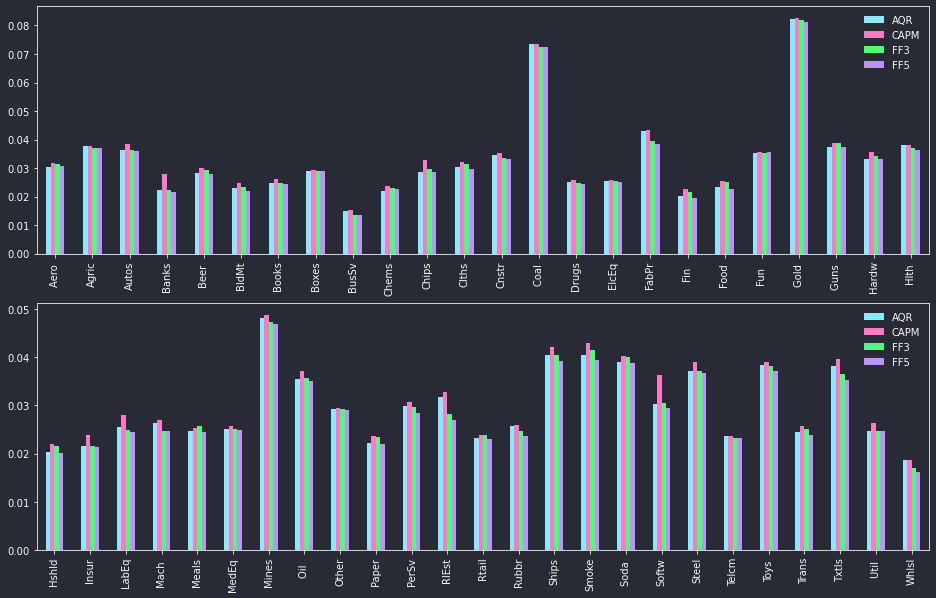

In [15]:
comp = pd.DataFrame({
    "AQR": aqr_ps["mae"],
    "CAPM": capm_ps["mae"],
    "FF3": ff3_ps["mae"],
    "FF5": ff5_ps["mae"],
})


fig, axs = plt.subplots(2)
n = comp.shape[0] // 2

comp.iloc[:n].plot.bar(ax=axs[0])
comp.iloc[n:].plot.bar(ax=axs[1])

plt.show()

In [16]:
best = comp.sum().to_frame().idxmin()[0]

gt = {}

for c in comp.drop(best, axis=1).columns:
    gt[c] = comp[c] > comp[best]

gt = pd.DataFrame(gt).sum() / comp.shape[0]
print(f"The model that fits the best is {best}.\n")
print(f"Probability that {best} has a lower MSE than other factor models:")
gt

The model that fits the best is FF5.

Probability that FF5 has a lower MSE than other factor models:


AQR    0.8776
CAPM   1.0000
FF3    0.9388
dtype: float64

#### 3. Does any particular factor seem especially important or unimportant for pricing? Do you think Fama and French should use the Momentum Factor?

The total market factor is unequivocally the most important. Trivial observations aside, High Minus Low's valuestyle is also very prominent in Fama-French and AQR. The two best performing factor models also use Robust Minus Weak's profitability indicator. The absence of Small Minus Big may not be too impactful in decomposition as AQR's model performs better than Fama-French 3 Factor and CAPM.

#### 4. This does not matter for pricing, but report the average (across n estimations) of the time-series regression r-squared statistics. Do this for each of the three models you tested. Do these models lead to high time-series r-squared stats? That is, would these factors be good in a Linear Factor Decomposition of the assets?

Yes the three models have adjusted $R^2$ stats between 0.5 and 0.6 indicating high predictive value. However, if we are strict in our interpretation of adjusted $R^2$ and reject CAPM for decompositon, no other model performed substantially better than CAPM.

In [17]:
rsq = pd.DataFrame({
    "AQR": aqr_ps["adj_r2"],
    "CAPM": capm_ps["adj_r2"],
    "FF3": ff3_ps["adj_r2"],
    "FF5": ff5_ps["adj_r2"],
})

rsq.mean()

AQR    0.5746
CAPM   0.5273
FF3    0.5699
FF5    0.5946
dtype: float64